# Create BGC initial condition for regional MITgcm based on GLODAPv2 and Huang et al (2022) Fe
    - For DIC, Alk, O2, NO3, PO4, we will use GLODAPv2 https://glodap.info/
    - For Fe, we use the gridded data of Huang et al., (2022) https://zenodo.org/record/6994318

In [1]:
import numpy as np
import xarray as xr
import xmitgcm as xm
import os
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [47]:
print('===== develop init cond ')
vars0 = ['tco2', 'talk', 'oxygen', 'phosphate', 'nitrate', 'dFe_RF']
vars1 = ['dic', 'alk', 'o2', 'po4', 'no3', 'fe']
srcdir = './GLODAPv2_Mapped_Climatologies'
caseroot = './'
ffe='Monthly_dFe_V2.nc'

===== develop init cond 


In [48]:
# define new grid
runcase = 'NorthPacific.lonlat2x2.42lev'
rname = 'NorthPacific'
xrange = [131, 249]  # zonal extent
yrange = [5, 62]  # meridional extent
n = [60, 40]   # number of grid points

In [49]:
#define a new grid coordinates
xn = np.linspace(xrange[0], xrange[1], n[0])
yn = np.linspace(yrange[0], yrange[1], n[1])
zn=np.array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float) * -1
#
# print the values of x0 and y0
x0 = xn[0]-(xn[1]-xn[0])/2.
y0 = yn[0]-(yn[1]-yn[0])/2.
print('x0='+str(x0))
print('y0='+str(y0))
#
# print the number of grid points in x, y and z
print('Nx='+str(xn.size))
print('Ny='+str(yn.size))
print('Nz='+str(zn.size))

x0=130.0
y0=4.269230769230769
Nx=60
Ny=40
Nz=42


In [51]:
vref = [2000, 2300, 170, 2, 30, 1e-3]
dx = np.diff(xn)
dy = np.diff(yn)
Nt = 1
# initialize array
N=n
tmp = np.zeros((6, N[0], N[1]))

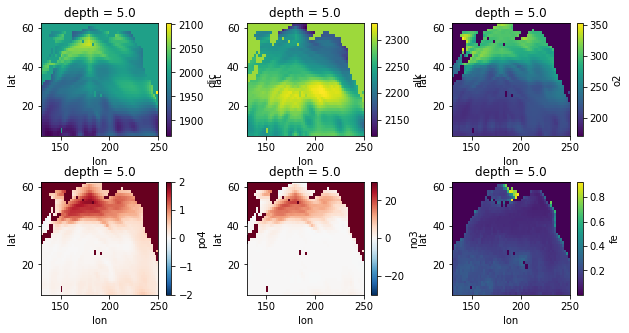

In [57]:
fig=plt.figure(figsize=(10,5))
ax=fig.subplots(2,3)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
#
for nv in range(6):
    if nv==5:
        ds=xr.open_dataset(ffe)
        fac=1e-3
        ds['Longitude']=ds['Longitude']+180
        x=ds.Longitude.to_numpy()
        y=ds.Latitude.to_numpy()
        z=ds.Depth.to_numpy()
        z[0]=0
        data = ds[vars0[nv]].roll(Longitude=int(360/2))
    else:
        ds=xr.open_dataset(srcdir+'/GLODAPv2.'+vars0[nv]+'.nc')
        fac=1
        ds['lon']=ds['lon']+180
        x=ds.lon.to_numpy()
        y=ds.lat.to_numpy()
        z=ds.Pressure.to_numpy()
        # roll longitude coordinate
        data = ds[vars0[nv]].roll(lon=int(360/2))
    #
    if nv==0:
        data0 = data[0,:,:,:].to_numpy()
    elif nv==5:
        data0 = data[12,:,:,:].to_numpy()
    else:
        data0=data.to_numpy()
    da=xr.DataArray(data=data0,name=vars1[nv],dims=['depth','lat','lon'],
               coords={'depth':z,'lat':y,'lon':x})
    ds1=da.to_dataset()
    wn = vars1[nv]+'_ini.bin'
    dst = ds1[vars1[nv]].interp(lon=xn,lat=yn,depth=zn).fillna(vref[nv])
    tdata=dst.to_numpy()
    xm.utils.write_to_binary(tdata.flatten(), wn)
#
    n=nv%3
    m=int(np.floor(nv/3))
    dst.isel(depth=0).plot(ax=ax[m,n])
#
plt.savefig('bgc_initcond.png',bbox_to_inches='tight')